# Sci-Plex 2 Notebook

In [1]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install cpa-tools
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/theislab/cpa

In [2]:
from sklearn.metrics import r2_score
import numpy as np

import os
os.chdir('/home/mohsen/projects/cpa/')
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import cpa
import scanpy as sc

Global seed set to 0


In [4]:
sc.settings.set_figure_params(dpi=100)

In [5]:
data_path = '/home/mohsen/projects/cpa/datasets/GSM_new.h5ad'

## Data Loading

In [6]:
adata = sc.read(data_path, backup_url='https://drive.google.com/u/0/uc?id=1ydi1IU9DvR1TRazkMboDvgEaiaNunEVV&export=download&confirm=t')
adata

AnnData object with n_obs × n_vars = 14811 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Data preparation

__IMPORTANT__: Currenlty because of the standartized evaluation procedure, we need to provide adata.obs['control'] (0 if not control, 1 for cells to use as control). And we also need to provide de_genes in .uns['rank_genes_groups']. 

In [7]:
cpa.CPA.setup_anndata(adata, 
                      drug_key='condition',
                      dose_key='dose_val',
                      categorical_covariate_keys=['cell_type'],
                      control_key='control',
                     )

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 14811 cells, 4999 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 14811/14811 [00:01<00:00, 8689.40it/s]


## Training the model

You can specify all the parameters for the model in a dictionary of parameters. If they are not specified, default values will be selected.

* `ae_params` are technical parameters of the architecture of the autoencoder.
    * `autoencoder_depth`: number of hidden layers in autoencoder 
    * `autoencoder_width`: number of hidden neurons in each hidden layer of autoencoder
    * `adversary_depth`: number of hidden layers in adversarial classifiers
    * `adversary_width`: number of hidden neurons in each hidden layer of adversarial classifiers
    * `use_batch_norm`: if `True`, batch normalization will be used in all networks 
    * `use_layer_norm`: if `True`, layer normalization will be used in all networks
    * `output_activation`: Must be one of `linear` or `relu`. Output activation used in the last layer of autoencoder 
    * `dropout_rate`: Must be between 0.0 and 1.0. Dropout probability used in hidden layers of all networks
    * `variational`: if `True`, variational autoencoder will be employed as the main perturbation response predictor
    * `seed`: number for setting the seed for generating random numbers.
* `trainer_params` are training parameters of CPA.
    * `n_epochs_warmup`: Number of epoch to pre-train autoencoder before adversarial training begins.
    * `adversary_lr`: learning rate of adversarial classifiers
    * `adversary_wd`: weight decay rate of adversarial classifiers
    * `adversary_steps`: Number of steps where used to train adversarial classifiers after a single step of training the autoencoder
    * `autoencoder_lr`: learning rate of the autoencoder
    * `autoencoder_wd`: weight decay rate of autoencoder
    * `dosers_lr`: learning rate of dosers parameters
    * `dosers_wd`: weight decay rate of dosers parameters
    * `penalty_adversary`: coefficient of penalty for adversarial classifiers
    * `reg_adversary`: coefficient of cross entropy losses in autoencoder training step
    * `kl_weight`: KL Divergence coefficient. This will be used when `variational` is set to True.
    * `step_size_lr`: learning rate step 

In [8]:
ae_hparams = {'autoencoder_depth': 4,
              'autoencoder_width': 512,
              'adversary_depth': 3,
              'adversary_width': 256,
              'use_batch_norm': True,
              'use_layer_norm': False,
              'output_activation': 'linear',
              'dropout_rate': 0.0,
              'variational': False,
              'seed': 60,
              }

trainer_params = {
    'n_epochs_warmup': 0,
    'adversary_lr': 0.0006158304832265454,
    'adversary_wd': 3.546249921082396e-06,
    'adversary_steps': 5,
    'autoencoder_lr': 0.002563090275772759,
    'autoencoder_wd': 2.8299682410882683e-05,
    'dosers_lr': 0.0028643381083830787,
    'dosers_wd': 7.850495446598981e-07,
    'penalty_adversary': 6.20968938643343,
    'reg_adversary': 1.323092865499999,
    'kl_weight': 0.00000,
    'step_size_lr': 45,
}

## Model instantiation

__NOTE__: Run the following 3 cells if you haven't already trained CPA from scratch.

Here, we create a CPA model using `cpa.CPA` given all hyper-parameters defined above and some additional parameters:
    
* `n_latent`: Number of latent dimensions
* `loss_ae`: Autoencoder's reconstruction loss. For now, only `gauss` is supported.
* `doser_type`: Doser network type. Must be one of `logsigm`, `sigm`, or `mlp`.
* `split_key`: split column in `adata.obs` dataframe which contains train/test/ood split information of cells.

In [9]:
model = cpa.CPA(adata=adata, 
                n_latent=256,
                loss_ae='gauss',
                doser_type='logsigm',
                split_key='split',
                **ae_hparams,
               )

Global seed set to 60


## Training CPA

After creating a CPA object, we train the model with the following arguments:
* `max_epochs`: Maximum number of epochs to train the models.
* `use_gpu`: If `True`, will use the available GPU to train the model.
* `batch_size`: Number of samples to use in each mini-batches.
* `early_stopping_patience`: Number of epochs with no improvement in early stopping callback.
* `check_val_every_n_epoch`: Interval of checking validation losses.
* `save_path`: Path to save the model after the training has finished.

In [10]:
model.train(max_epochs=1500,
            use_gpu=True, 
            batch_size=64,
            plan_kwargs=trainer_params,
            early_stopping_patience=15,
            check_val_every_n_epoch=20,
            save_path='/home/mohsen/projects/cpa/lightning_logs/GSM_new/',
           )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name   | Type      | Params
-------------------------------------
0 | module | CPAModule | 9.6 M 
-------------------------------------
9.6 M     Trainable params
0         Non-trainable params
9.6 M     Total params
38.252    Total estimated model params size (MB)


Epoch 1300/1500:  87%|▊| 1300/1500 [1:59:46<18:25,  5.53s/it, recon=-.293, adv_loss=0.494, val_recon=-1.44, val_disnt_basal=0.228, val_disnt_after=0.9


## Plot training history
Plots the losses and metrics used to monitor CPA's training.

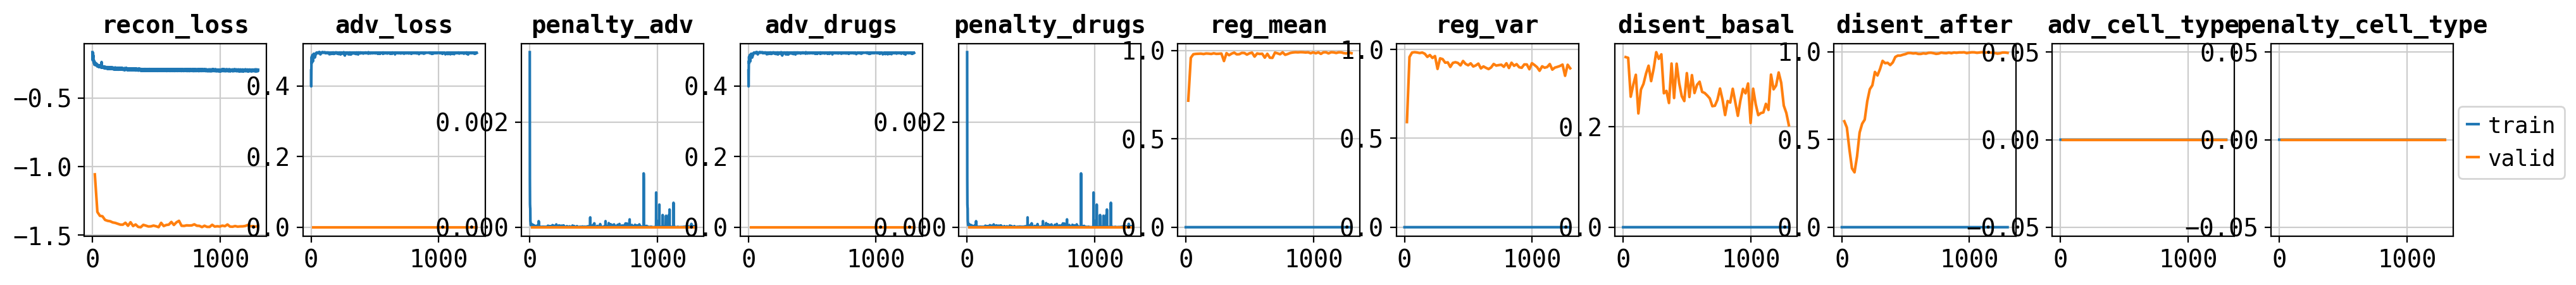

In [11]:
cpa.pl.plot_history(model)

## Load pre-trained model

If you already trained CPA, you can restore model weights by running the following cell:

In [12]:
# model = cpa.CPA.load('lightning_logs/GSM_new/', adata, use_gpu=True)

## Latent space UMAP visualization

Here, we visualize the latent representations of (OOD + test) cells. We computed basal and final latent representations with `model.get_latent_representation` function. 

In [13]:
test_dataset = adata[adata.obs['split'] != 'train']

In [14]:
latent_basal_adata, latent_adata = model.get_latent_representation(test_dataset, batch_size=1024)

In [15]:
sc.pp.neighbors(latent_basal_adata)
sc.tl.umap(latent_basal_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


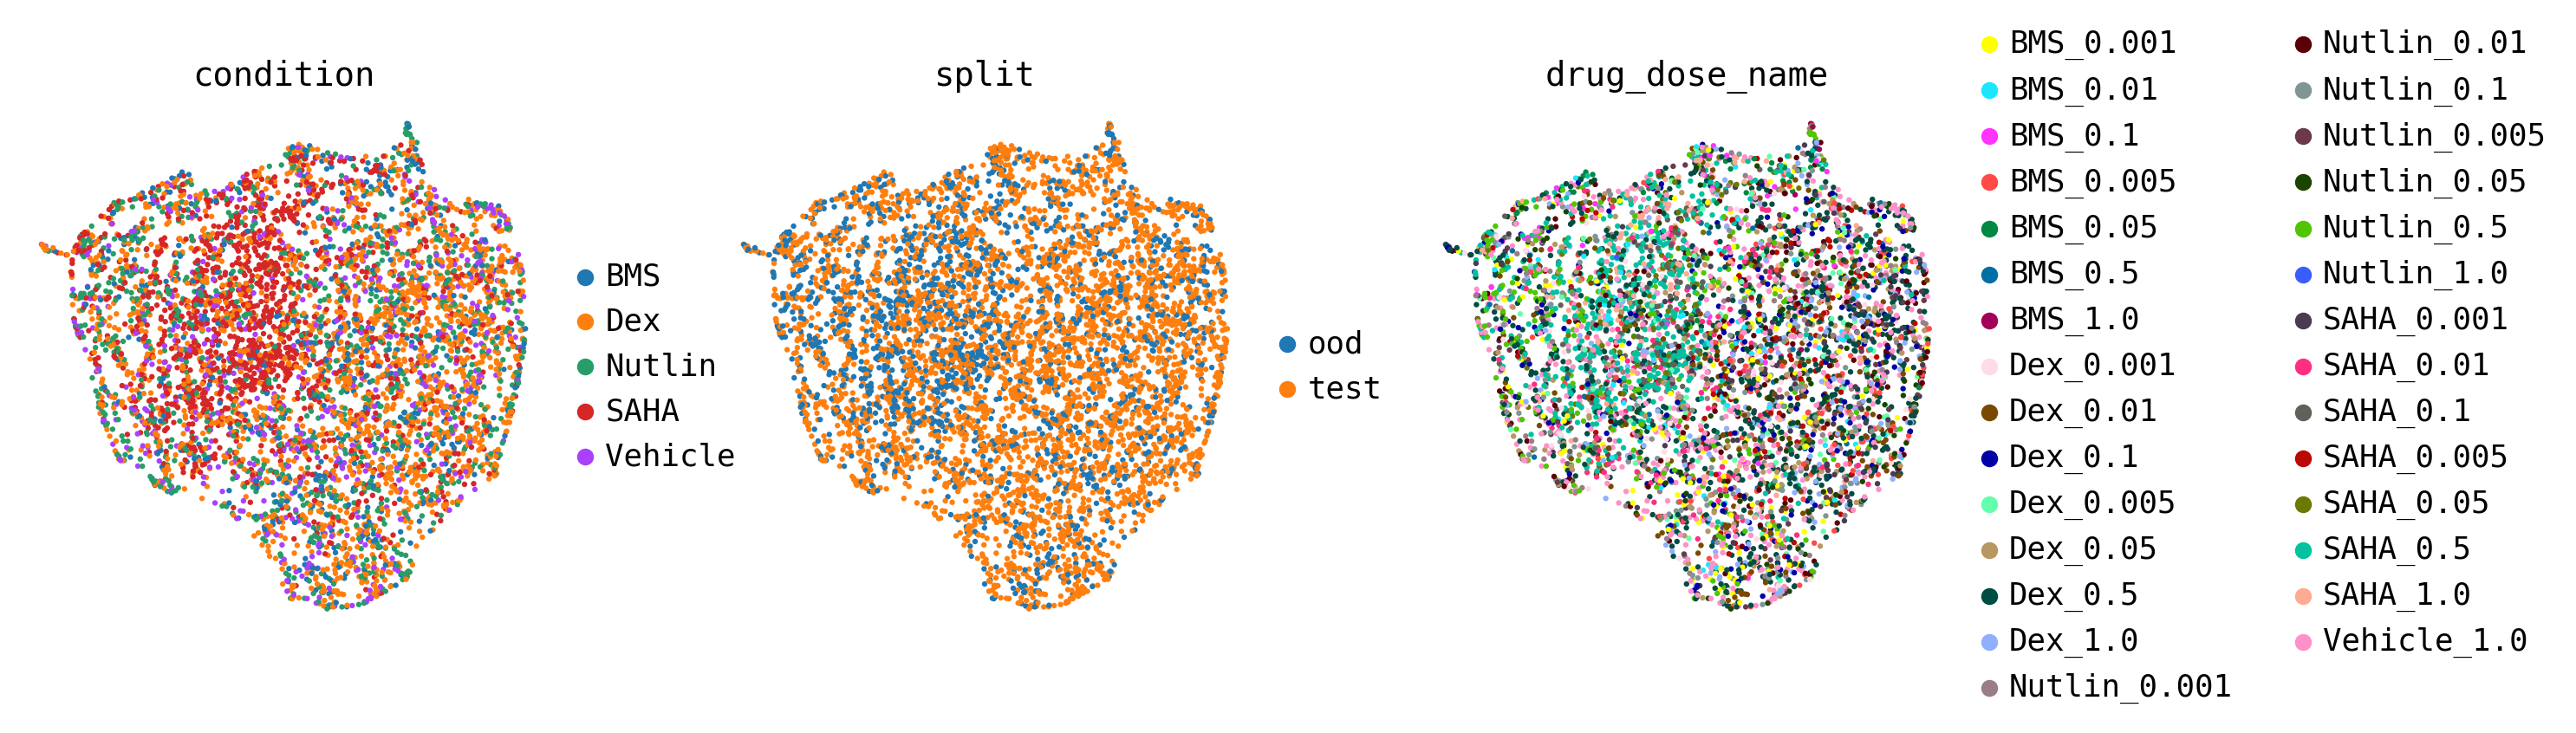

In [16]:
sc.pl.umap(latent_basal_adata, color=['condition', 'split', 'drug_dose_name'], frameon=False, wspace=0.2)

In [17]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


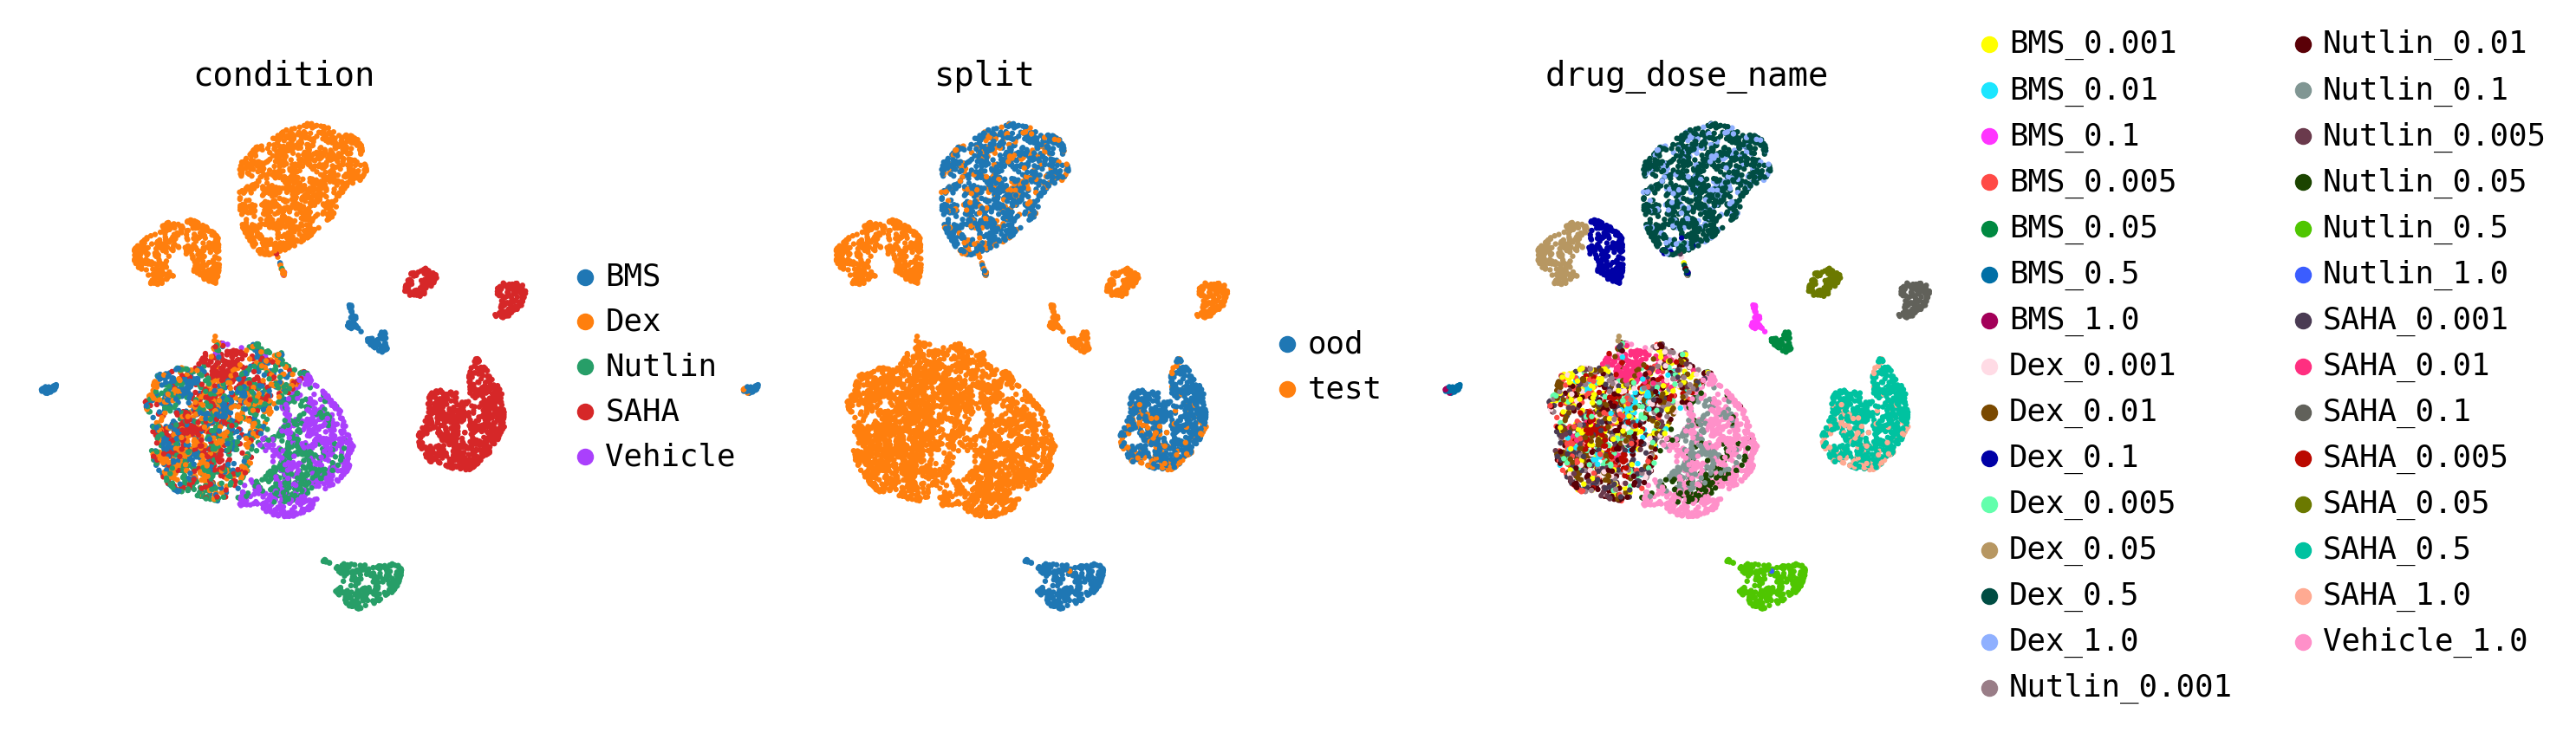

In [18]:
sc.pl.umap(latent_adata, color=['condition', 'split', 'drug_dose_name'], frameon=False, wspace=0.2)

In [19]:
pred_adata_mean, pred_adata_var = model.predict(test_dataset, batch_size=128)

All genes var:  0.013829013990098948


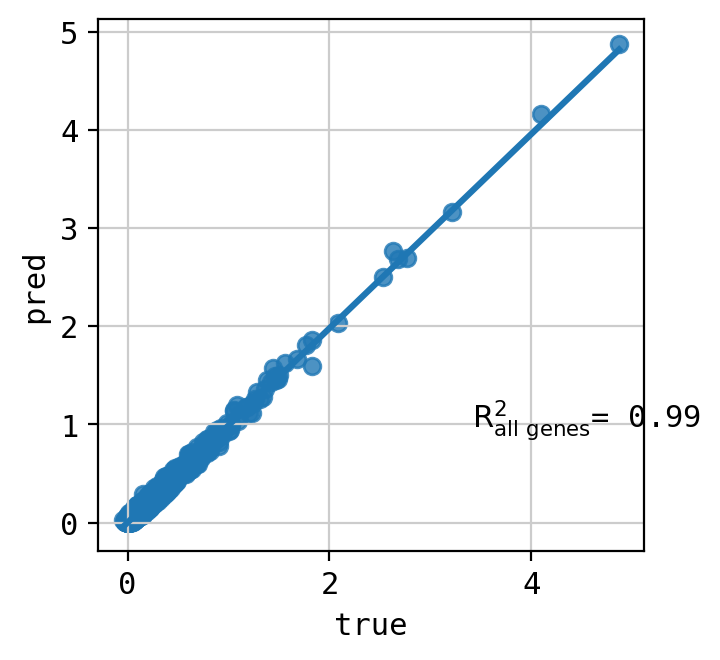

0.9886705733171689

In [20]:
cpa.pl.mean_plot(test_dataset, pred_adata_mean, None, None, None, show=True, verbose=True)

## Compert API for compatibility with scanpy

In [21]:
cpa_api = cpa.ComPertAPI(adata, model)

In [22]:
cpa_plots = cpa.pl.CompertVisuals(cpa_api, fileprefix=None)

In [23]:
cpa_api.num_measured_points['train']

{'A549_BMS_0.001': 442,
 'A549_BMS_0.005': 391,
 'A549_BMS_0.01': 262,
 'A549_BMS_0.05': 134,
 'A549_BMS_0.1': 103,
 'A549_BMS_1.0': 13,
 'A549_Dex_0.001': 204,
 'A549_Dex_0.005': 264,
 'A549_Dex_0.01': 479,
 'A549_Dex_0.05': 484,
 'A549_Dex_0.1': 486,
 'A549_Dex_1.0': 568,
 'A549_Nutlin_0.001': 284,
 'A549_Nutlin_0.005': 252,
 'A549_Nutlin_0.01': 387,
 'A549_Nutlin_0.05': 350,
 'A549_Nutlin_0.1': 457,
 'A549_Nutlin_1.0': 6,
 'A549_SAHA_0.001': 392,
 'A549_SAHA_0.005': 376,
 'A549_SAHA_0.01': 383,
 'A549_SAHA_0.05': 299,
 'A549_SAHA_0.1': 297,
 'A549_SAHA_1.0': 282,
 'A549_Vehicle_1.0': 1535}

In [24]:
drug_adata = cpa_api.get_drug_embeddings()
drug_adata.shape

(5, 128)

In [25]:
drug_adata.obs.condition

0    Vehicle
1        Dex
2       SAHA
3        BMS
4     Nutlin
Name: condition, dtype: object

In [26]:
cpa_plots.unique_perts

['Vehicle', 'Dex', 'SAHA', 'BMS', 'Nutlin']

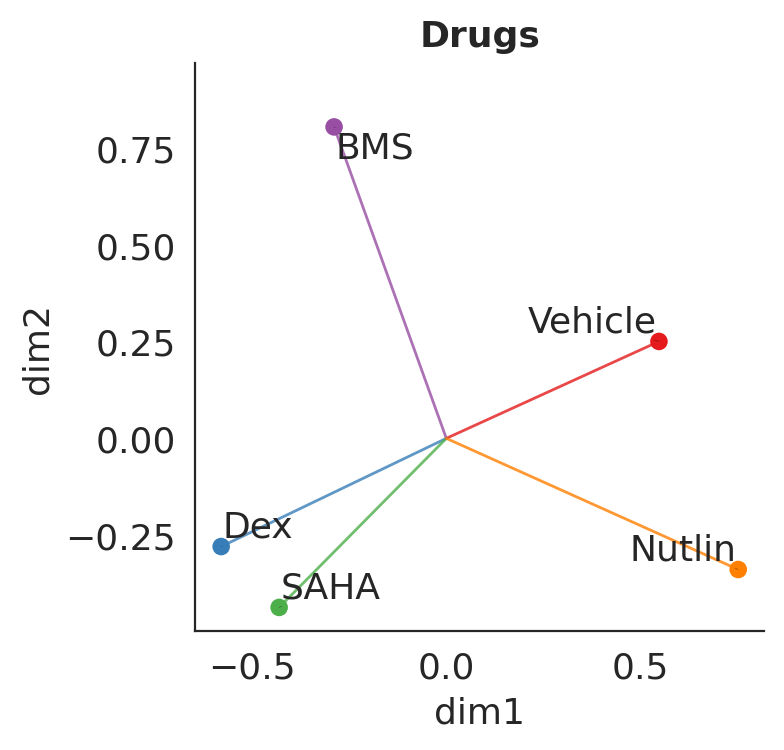

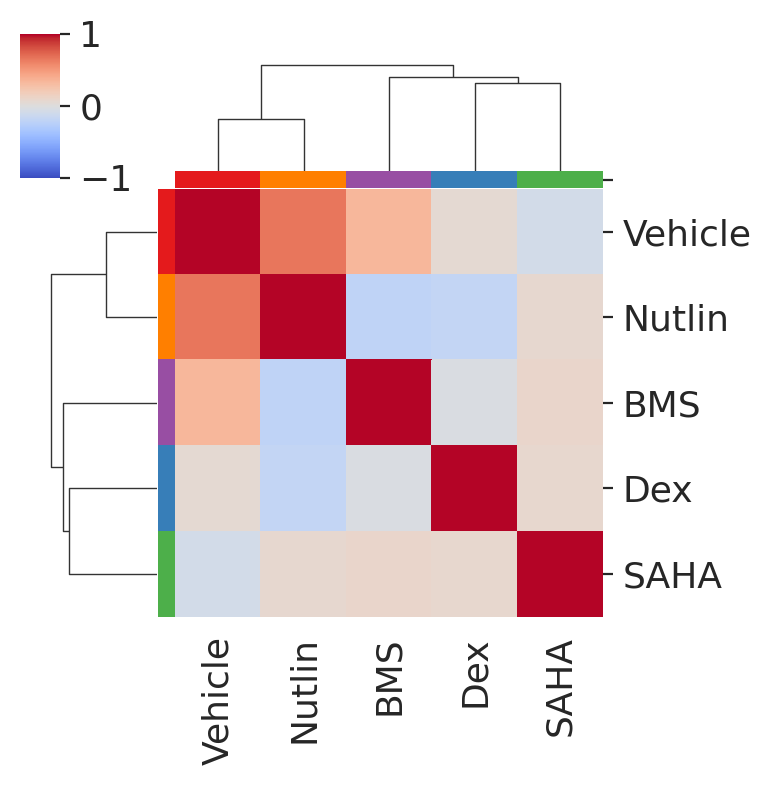

In [27]:
cpa_plots.plot_latent_embeddings(drug_adata.X, kind='perturbations', titlename='Drugs')

In [28]:
cpa_api.compute_comb_emb(thrh=30)

In [29]:
cpa_api.compute_uncertainty(
                    covs=['A549'], 
                    pert='Nutlin', 
                    dose=1.0
                )

(5.38826e-05, 0.13716096, 'A549_Nutlin_0.1', 'A549_Nutlin_0.1')

In [30]:
cpa_api.measured_points['train']

{'A549': {'BMS': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Dex': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Nutlin': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'SAHA': [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
  'Vehicle': [1.0]}}

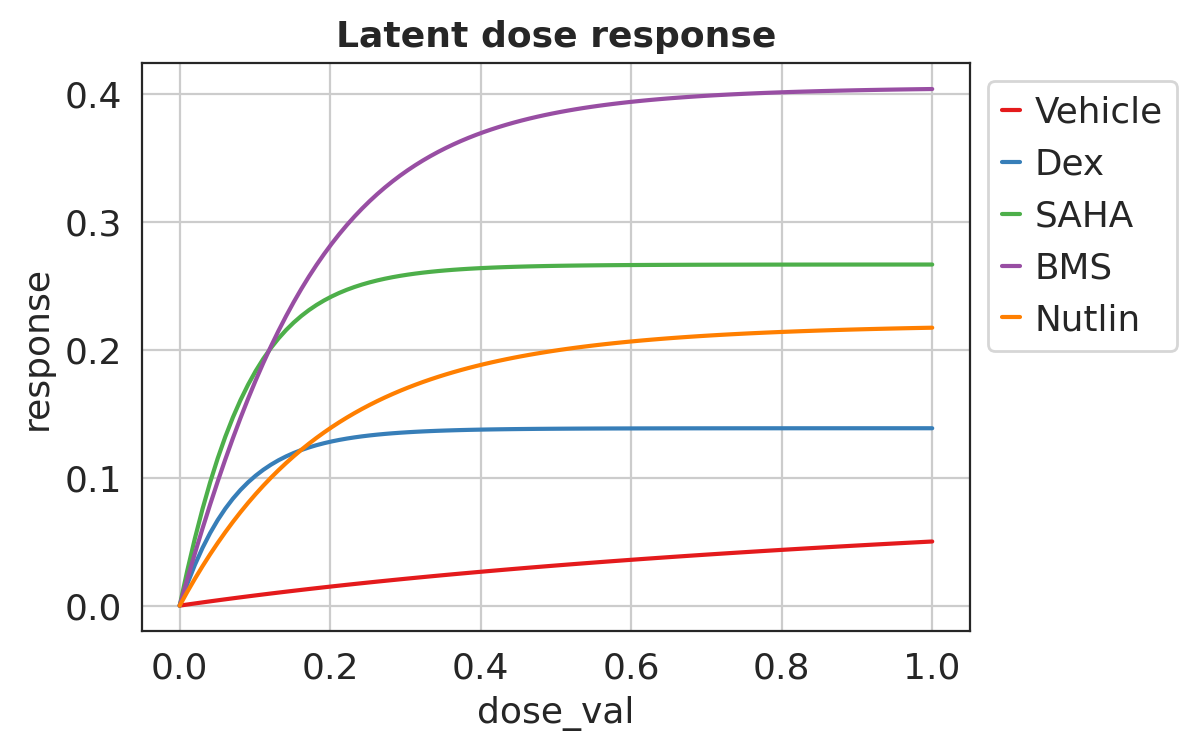

In [31]:
from matplotlib import pyplot as plt
latent_response = cpa_api.latent_dose_response()
cpa_plots.plot_contvar_response(
    latent_response, 
    postfix='latent',
    var_name=cpa_api.perturbation_key,
    title_name='Latent dose response')
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [34]:
scores = cpa_api.evaluate_r2(list(adata[adata.obs['split'] == 'ood'].obs['condition'].unique()))
scores

INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'drugs_doses', 'cell_type']        
INFO     Successfully registered anndata object containing 620 cells, 4999 vars, 1 batches, 1
         labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra  
         continuous covariates.                                                              
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'drugs_doses', 'cell_type']        
INFO     Successfully registered anndata object containing 620 cells, 4999 vars, 1 batches, 1
         labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra  
         continuous covariates.                                                              
INFO     Using data from adata.X                            

,cell_type,condition,dose_val,R2_mean,R2_mean_DE,R2_var,R2_var_DE,num_cells
0,A549,BMS,0.001,0.962078,0.950276,0.899802,0.153299,654
1,A549,BMS,0.005,0.980508,0.996081,0.947882,0.721254,542
2,A549,BMS,0.01,0.961333,0.817274,0.901042,-0.005706,344
3,A549,BMS,0.05,0.920166,0.838041,0.741800,-1.102766,193
4,A549,BMS,0.1,0.932221,0.867702,0.820898,0.353883,153
5,A549,BMS,0.5,0.938280,0.897180,0.735398,0.402556,34
6,A549,BMS,1.0,0.808387,0.162433,0.464434,-0.535409,19
7,A549,Dex,0.001,0.976889,0.957739,0.949690,0.478361,327
8,A549,Dex,0.005,0.984155,0.971819,0.966344,0.699062,372
9,A549,Dex,0.01,0.985510,0.961085,0.959533,0.180166,717


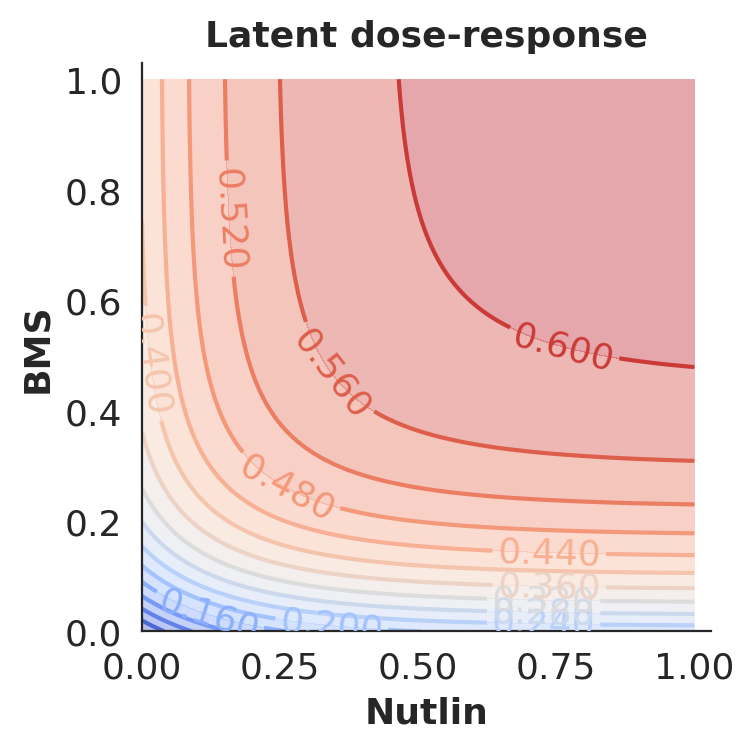

In [35]:
perturbations_pair = ['Nutlin', 'BMS']
latent_dose_2D = cpa_api.latent_dose_response2D(perturbations_pair, n_points=100)
cpa_plots.plot_contvar_response2D(latent_dose_2D, 
        title_name='Latent dose-response')

In [36]:
# %%time
df_reference = cpa_api.get_response_reference() 
df_reference.head()

,cell_type,condition,dose_val,split,num_cells,response,SCYL3,C1orf112,GCLC,STPG1,...,AL589669.1,AL391117.1,AC092718.8,AC015802.6,AC087565.3,AC006511.5,AC079781.5,AL034417.3,AC087269.2,AL358472.5
0,A549,BMS,0.001,training_treated,442,1.774326,-0.003192,-0.016493,0.029825,-0.008942,...,0.002200,-0.008055,0.000136,0.000687,-0.008671,-0.000800,-0.010130,0.008315,0.002090,0.000823
1,A549,BMS,0.005,training_treated,391,2.927792,0.007327,-0.006961,-0.233149,-0.004181,...,-0.000393,-0.002095,-0.003447,-0.007889,-0.008073,0.011643,0.013168,0.035325,0.002095,-0.002024
2,A549,BMS,0.010,training_treated,262,6.275605,-0.034505,-0.045197,-0.214411,0.006304,...,0.004329,0.001807,-0.008037,-0.002487,0.008677,0.030816,-0.021999,-0.004749,-0.004152,0.004708
3,A549,BMS,0.050,training_treated,134,6.652686,-0.006467,0.111383,-0.547656,0.005964,...,-0.004001,0.034350,0.006300,0.003914,0.070792,-0.007431,-0.002193,0.012284,-0.000201,0.011610
4,A549,BMS,0.100,training_treated,103,5.900538,-0.041323,-0.026907,-0.458251,-0.010185,...,-0.004001,0.004597,-0.003435,0.013101,0.017064,-0.007431,-0.003163,0.008514,-0.005585,-0.006553


In [ ]:
# %%time
reconstructed_response = cpa_api.get_response()

In [38]:
reconstructed_response['source'] = 'pred'
df_reference['source'] = 'true'

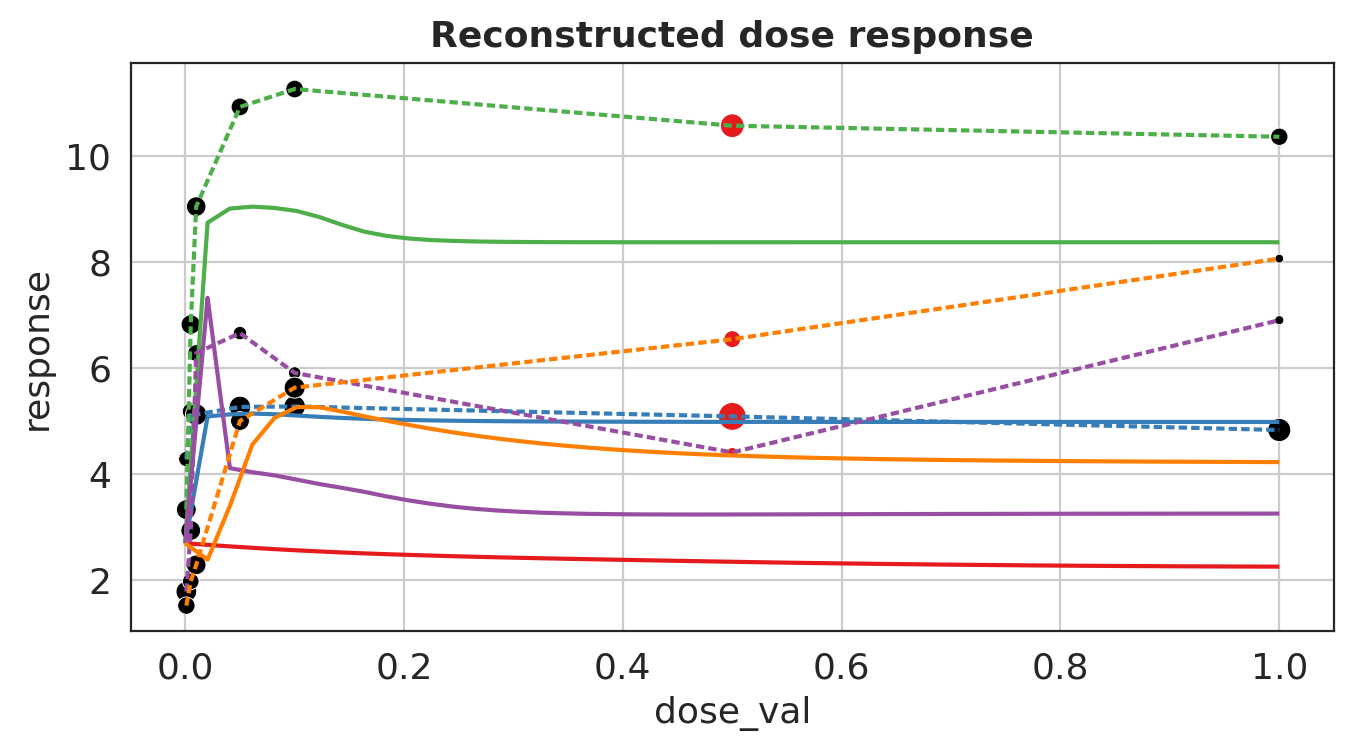

In [39]:
cpa_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference, 
    postfix='reconstructed',
    ref_name='source',
    title_name='Reconstructed dose response',
    legend=True,
)

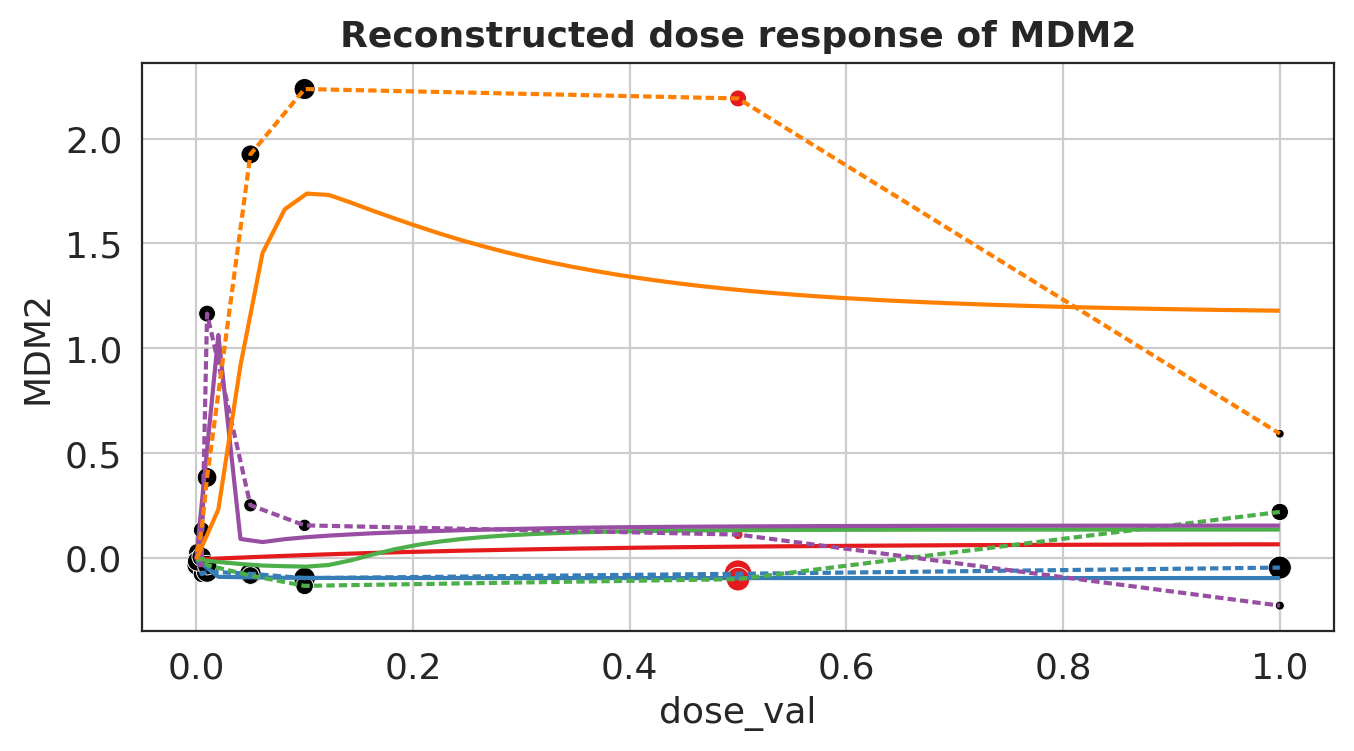

In [40]:
cpa_plots.plot_contvar_response(
    reconstructed_response, 
    df_ref=df_reference,
    response_name='MDM2',
    postfix='MDM2',
    title_name='Reconstructed dose response of MDM2')

In [ ]:
reconstructed_response2D = cpa_api.get_response2D(['Nutlin', 'BMS'], cpa_api.unique_covars['cell_type'][0])

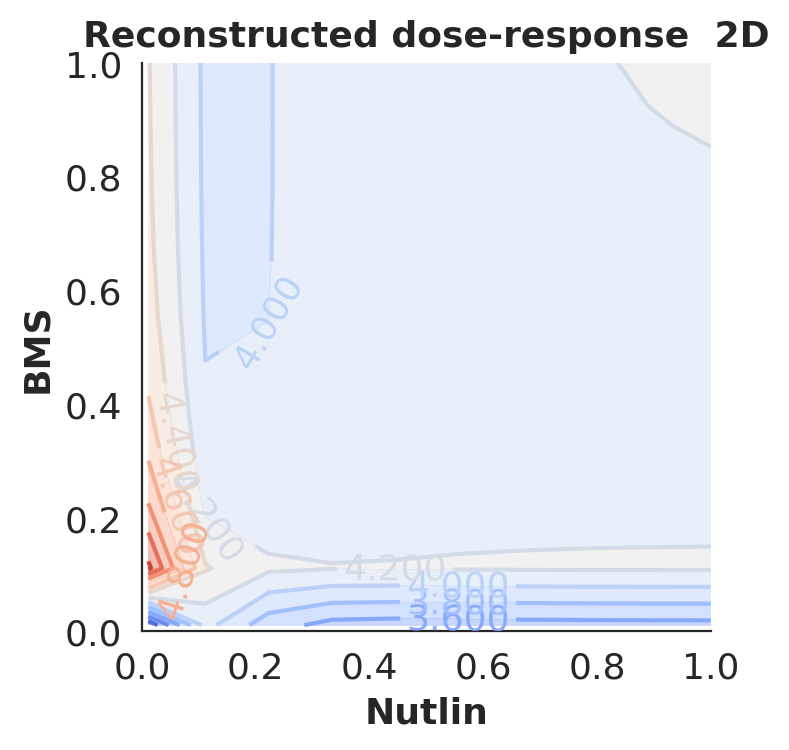

In [51]:
cpa_plots.plot_contvar_response2D(reconstructed_response2D,
                                  title_name='Reconstructed dose-response  2D',
                                  logdose=False,
                                  xlims=(0, 1.0), ylims=(0, 1.0)
                                  )

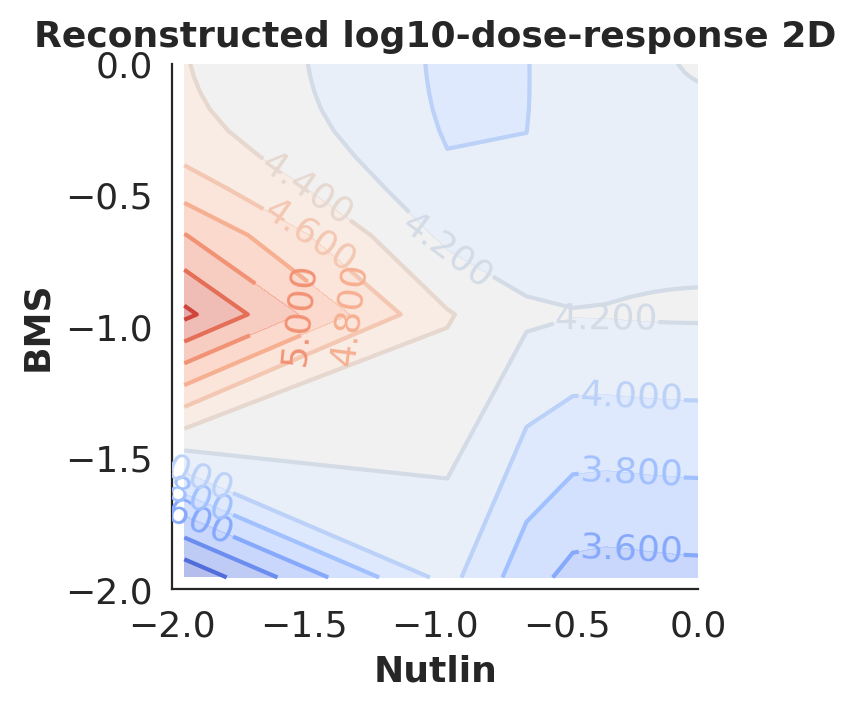

In [53]:
cpa_plots.plot_contvar_response2D(reconstructed_response2D,
                                  title_name='Reconstructed log10-dose-response 2D',
                                  logdose=True,
                                  xlims=(-2, 0), ylims=(-2, 0)
                                  )

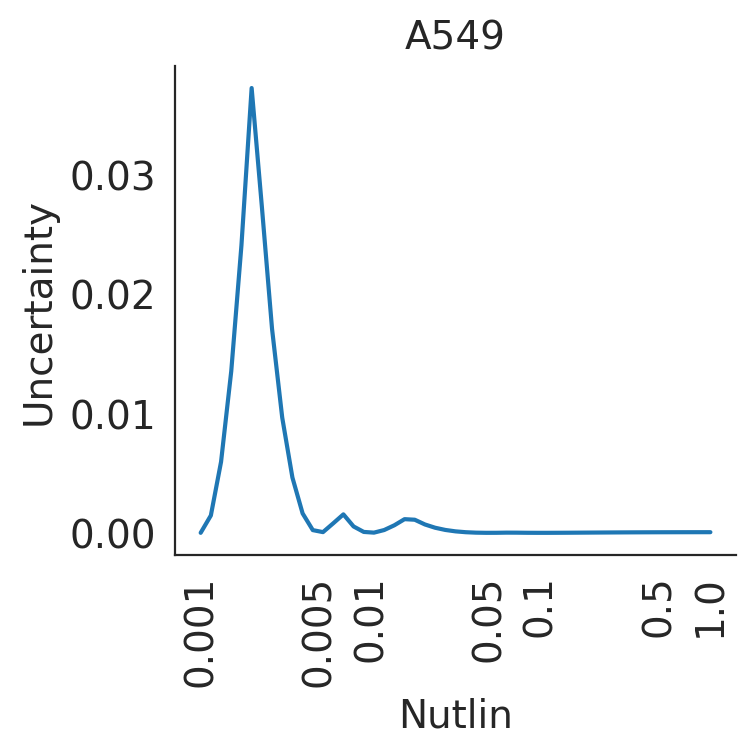

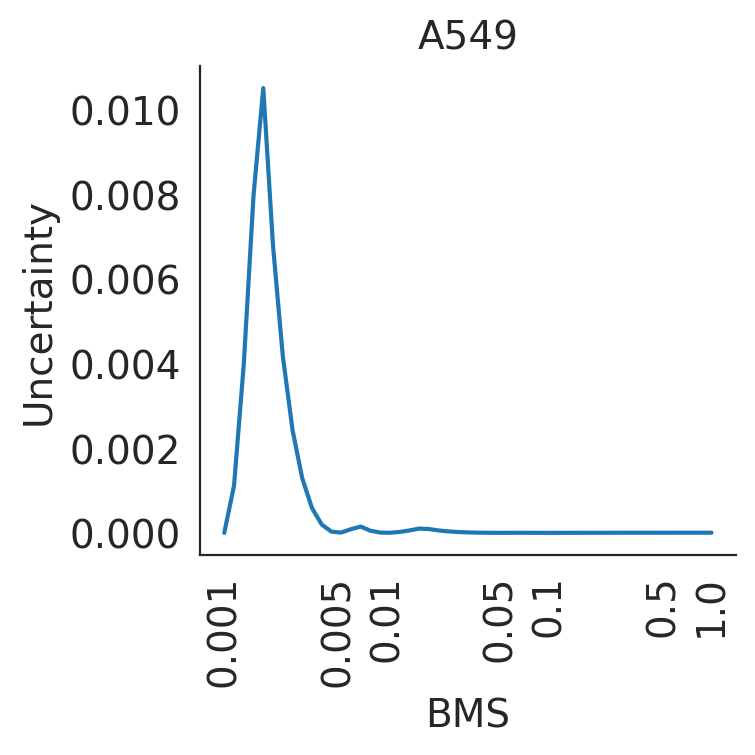

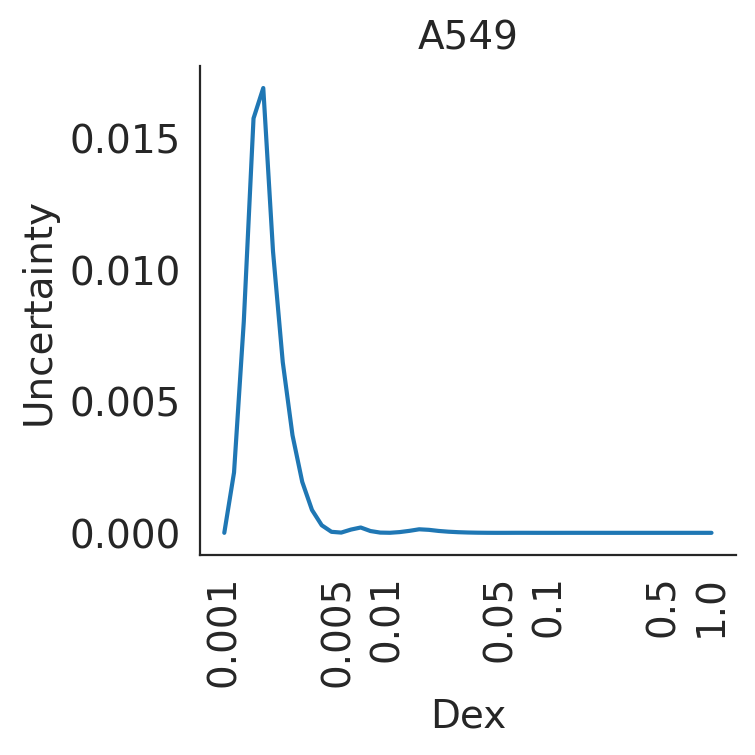

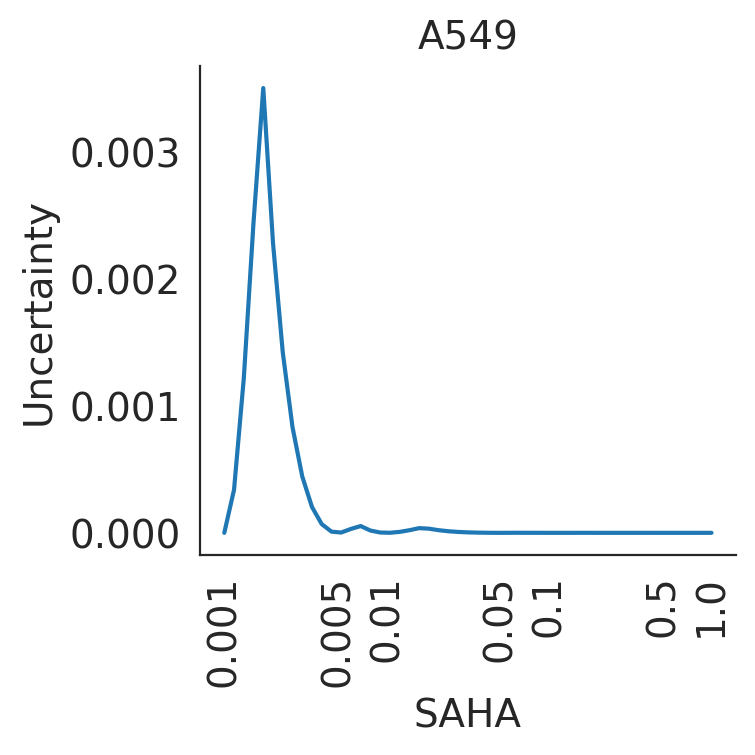

In [54]:
for drug in ['Nutlin', 'BMS', 'Dex', 'SAHA']:
    df_pred = cpa.pl.plot_uncertainty_dose(
        cpa_api,
        cov='A549',
        pert=drug,
        N=51,
        measured_points=cpa_api.measured_points['all'],
        cond_key='condition',
        log=True,
        metric='cosine'
    )